![DataScienceSeed Logo](http://www.datascienceseed.com/wp-content/uploads/2018/02/dsst.jpg)
## Dataset Hands-On Challenge 
Marcello's working notebook on the [Flairbit](http://www.flairb.it/) Challenge presented on the February 7 2019 event:

http://www.datascienceseed.com/2019/02/10/dataset-challenge-hands-on-1-flairbit-coffee-machines-rulex-churn-service/

Dataset details and download instructions are at the link above, in the Flairbit section of the event.

## The dataset
* Data related to professional coffe machines
* Dataset categories:
    * Counters
    * Cleanings
    * Faults
* One file per category per day
    *type_YYYYMMDDHHMMSS-an.csv (e.g., faults_20190103020001-an.csv)
* Common dataset feature
    * Machine serial number
    * Machine model
    * Timestamp (YYYY MM DD hh:mm:ss and week number)



**counters**

Serial | YYYY | MM | dd | hh:mm:ss | Week | Model | LabelCounter | AbsoluteCounter | RelativeCounter
-------|------|----|----|----------|------|-------|--------------|-----------------|----------------
1535632 | 2016 | 11 | 29 | 04:00:07 | 49 | model 31 | numcaffegenerale | 179112 | 0
1535632 | 2016 | 11 | 29 | 05:00:07 | 49 | model 31 | numcaffegenerale | 179120 | 8
1535632 | 2016 | 11 | 29 | 06:00:07 | 49 | model 31 | numcaffegenerale | 179158 | 38

**cleanings**

Serial | YYYY | MM | dd | hh:mm:ss | Week | Model | Errorcode 
-------|------|----|----|----------|------|-------|-----------
1535632 | 2016 | 11 | 29 | 04:00:07 | 49 | model 10 | 1
1535632 | 2016 | 11 | 29 | 05:00:07 | 49 | model 9 | 1 
1535632 | 2016 | 11 | 29 | 06:00:07 | 49 | model 31 |1 

**faults**

Serial | YYYY | MM | dd | hh:mm:ss | Week | Model | Errorcode | Critical 
-------|------|----|----|----------|------|-------|-----------|------------
1535632 | 2016 | 11 | 29 | 04:00:07 | 49 | model 62 | 185 | WARNING
1535632 | 2016 | 11 | 29 | 05:00:07 | 49 | model 20| 185 | WARNING
1535632 | 2016 | 11 | 29 | 06:00:07 | 49 | model 20 |185 | WARNING

### Warm up: Let’s query the CSV files
* How many connected machines?
* Counters types
* Faults distribution per model
* Cleanings misses distribution per model

## Challenges:

### Forecasting
* Predict faults occurrences based on counters patterns and cleaning misses

### Root cause analysis
* Find correlations between machine usage (counters and cleanings misses) and faults

## Credits
Thanks to [Flairbit](http://www.flairb.it/) for providing this dataset to the [DataScienceSeed](http://www.datascienceseed.com/) community! **This notebook has no commercial purpose** it is provided for educational purposes alone.
![Flairbit](https://www.alleantia.com/wp-content/uploads/2013/11/FlairBit.png)

https://github.com/mallibus/Flairbit-Coffee-Machines-DataWranglin

**Folder structure** 

This notebook is expected to be executed inside a folder at the same level of ```operational-data```, root folder of the dataset. The datset files are reached as `../operational-data/cleanings/*.csv`,`../operational-data/counters/*.csv`, `../operational-data/faults/*.csv`.

Please keep in the same folder of the notebook the small script ```progress.py```: it just implements a simple progress bar to avoid half an hour of staring at nothing while datset loads.




In [1]:
# Change this if the dataset is elsewhere
dataset_root = "../operational-data/"


# Let's prepare the scene

In [2]:
# Import some useful libraries (they are supposed to be installed in your python environment)

# Pandas is the workhorse of data analytics libraries in Python - 90% of your data wrangling will be in Pandas
import pandas as pd
# Numpy is the array machine - you just need it, soon or late
import numpy as np
# The following lines tell to Pandas that when it shows a data frame:
# I want to see up to 999 columns 
pd.options.display.max_columns = 999
# I want to see up to 20 rows
pd.options.display.max_rows = 30

# Matplotlib is the main data visualization libray in Python 
import matplotlib.pyplot as plt
# You need the following ugly stuff to access to the filesystem from Python
import sys, os, fnmatch
# And this is used for dates management
import datetime as dt

# The spell below tells to Jupyter Notebook that you want pictures in the cells
%matplotlib inline

In [3]:
# Import simple status bar from the file progress.py which is the the same folder of this notebook
from progress import progress


In [4]:
def load_files(folder=".",pattern="*.csv",how_many_files = -1):
    """ Utility function to load all the files of the a dataset category
    folder = relative path of the dataset files
    pattern = pattern to identify dataset files
    how_many_files = number of files to load. -1 stands for "ALL"
    """
    try:
        files = fnmatch.filter(os.listdir(folder),pattern)
    except:
        print("Problems in listing files inside folder:"+folder)
        print("No data loaded")
        return

    if how_many_files<=0:
        how_many_files = len(files)

    print("%s : loading %d files"%(folder,how_many_files))
    
    df = pd.DataFrame()
    for i,f in enumerate(files[:how_many_files]):
        progress(i, how_many_files-1, status='Loading files')
        df = pd.concat([df, pd.read_csv(folder+'/'+f,sep=";")])
        
    print('')
    return df

## Load the dataset

Loading all the files takes 20+ minutes on my PC. To run quick tests you can change `how_many_files` variable. Setit to -1 to load all files

In [5]:
how_many_files=-1 # -1 stands for ALL

In [5]:
# Let's take note of what time is it when start loading files... it will take a while
start = dt.datetime.now()

# Start with the big hog of counters... be patient
df_counters = load_files(folder=dataset_root+"counters",how_many_files=how_many_files)

../operational-data/counters : loading 395 files
[============================================================] 100.0% ...Loading files


In [14]:
# cleanings and faults are much faster
df_cleanings = load_files(folder=dataset_root+"cleanings",how_many_files=how_many_files)
df_faults = load_files(folder=dataset_root+"faults",how_many_files=how_many_files)
print((dt.datetime.now()-start))

../operational-data/cleanings : loading 391 files
[============================================================] 100.0% ...Loading files
../operational-data/faults : loading 395 files
[============================================================] 100.0% ...Loading files
0:30:32.666213


In [7]:
df_counters.to_pickle("counters.pkl")
df_cleanings.to_pickle("cleanings.pkl")
df_faults.to_pickle("faults.pkl")


In [6]:
start = dt.datetime.now()
df_counters = pd.read_pickle("counters.pkl")
df_cleanings = pd.read_pickle("cleanings.pkl")
df_faults = pd.read_pickle("faults.pkl")
print((dt.datetime.now()-start))

0:00:11.753253


## Let's see the data in its face!

In [7]:
df_counters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45330415 entries, 0 to 192929
Data columns (total 10 columns):
Serial             int64
YYYY               int64
MM                 int64
dd                 int64
hh:mm:ss           object
Week               int64
Model              object
LabelCounter       object
AbsoluteCounter    float64
RelativeCounter    float64
dtypes: float64(2), int64(5), object(3)
memory usage: 3.7+ GB


In [8]:
df_counters.head()

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,LabelCounter,AbsoluteCounter,RelativeCounter
0,1535632,2016,11,29,00:00:38,49,model 31,numcaffegenerale,179112.0,0.0
1,1535632,2016,11,29,01:00:07,49,model 31,numcaffegenerale,179112.0,0.0
2,1535632,2016,11,29,02:00:07,49,model 31,numcaffegenerale,179112.0,0.0
3,1535632,2016,11,29,03:00:07,49,model 31,numcaffegenerale,179112.0,0.0
4,1535632,2016,11,29,04:00:07,49,model 31,numcaffegenerale,179112.0,0.0


Let's see how counters work (on one machine, one counter type)

In [9]:
serial_mask = df_counters['Serial']==1535632
gencaffe_mask = df_counters['LabelCounter']=='numcaffegenerale'
date_mask = (df_counters['YYYY']==2016)&(df_counters['MM']==11)&(df_counters['dd']==29)

In [10]:
df_counters[serial_mask&gencaffe_mask&date_mask].head(20)

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,LabelCounter,AbsoluteCounter,RelativeCounter
0,1535632,2016,11,29,00:00:38,49,model 31,numcaffegenerale,179112.0,0.0
1,1535632,2016,11,29,01:00:07,49,model 31,numcaffegenerale,179112.0,0.0
2,1535632,2016,11,29,02:00:07,49,model 31,numcaffegenerale,179112.0,0.0
3,1535632,2016,11,29,03:00:07,49,model 31,numcaffegenerale,179112.0,0.0
4,1535632,2016,11,29,04:00:07,49,model 31,numcaffegenerale,179112.0,0.0
5,1535632,2016,11,29,05:00:07,49,model 31,numcaffegenerale,179120.0,8.0
6,1535632,2016,11,29,06:00:07,49,model 31,numcaffegenerale,179158.0,38.0
7,1535632,2016,11,29,07:00:07,49,model 31,numcaffegenerale,179228.0,70.0
8,1535632,2016,11,29,08:00:07,49,model 31,numcaffegenerale,179327.0,99.0
9,1535632,2016,11,29,09:00:07,49,model 31,numcaffegenerale,179427.0,100.0


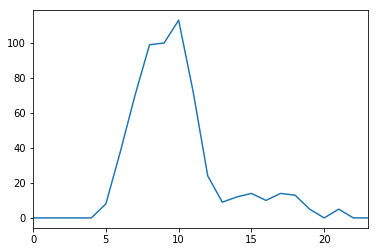

In [11]:
df_counters[serial_mask&gencaffe_mask&date_mask]['RelativeCounter'].plot()
plt.show()

Obviously absolute counter grows

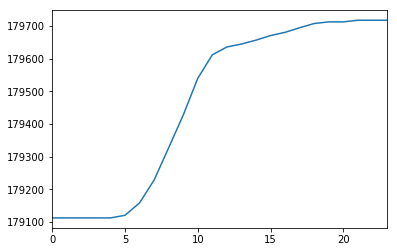

In [12]:
df_counters[serial_mask&gencaffe_mask&date_mask]['AbsoluteCounter'].plot()
plt.show()

Let's see if absolute number always grows in the life of the machine

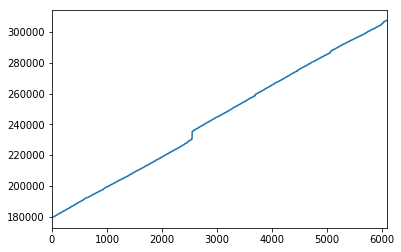

In [13]:
df_counters[serial_mask&gencaffe_mask].reset_index()['AbsoluteCounter'].plot()
plt.show()

Let's see the relative (hourly) counters for the whole life of the machine

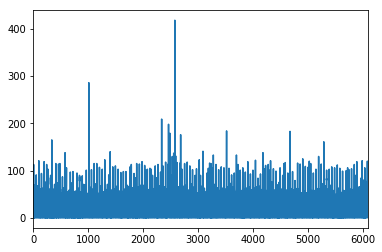

In [14]:
df_counters[serial_mask&gencaffe_mask].reset_index()['RelativeCounter'].plot()
plt.show()

In [15]:
index_max = df_counters[serial_mask&gencaffe_mask].reset_index()['RelativeCounter'].idxmax()
print("My finest hour...")
df_counters[serial_mask&gencaffe_mask].iloc[index_max]


My finest hour...


Serial                      1535632
YYYY                           2017
MM                                3
dd                               29
hh:mm:ss                   13:00:13
Week                             13
Model                      model 31
LabelCounter       numcaffegenerale
AbsoluteCounter              236160
RelativeCounter                 418
Name: 7, dtype: object

Remove records with no counters changes to reduce dataset size

In [16]:
df_counters.columns 

Index(['Serial', 'YYYY', 'MM', 'dd', 'hh:mm:ss', 'Week', 'Model',
       'LabelCounter', 'AbsoluteCounter', 'RelativeCounter'],
      dtype='object')

In [17]:
print("There are ",
        df_counters.duplicated(['Serial', 'YYYY', 'MM', 'dd', 'Week', 'Model',
               'LabelCounter', 'AbsoluteCounter'],keep='first').sum(),
      " useless lines in the dataset")

There are  31195146  useless lines in the dataset


In [18]:
df_counters = df_counters.drop_duplicates(['Serial', 'YYYY', 'MM', 'dd', 'Week', 'Model',
       'LabelCounter', 'AbsoluteCounter'],keep='first')

In [19]:
df_counters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14135269 entries, 0 to 192929
Data columns (total 10 columns):
Serial             int64
YYYY               int64
MM                 int64
dd                 int64
hh:mm:ss           object
Week               int64
Model              object
LabelCounter       object
AbsoluteCounter    float64
RelativeCounter    float64
dtypes: float64(2), int64(5), object(3)
memory usage: 1.2+ GB


Check out the memory saving!

In [20]:
df_cleanings.head()

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,ErrorCode
0,1527654,2016,11,29,01:00:13,49,model 10,1
1,1496767,2016,11,29,00:00:00,49,model 7,1
2,1557536,2016,11,29,08:00:49,49,model 10,2
3,1558474,2016,11,29,01:00:35,49,model 9,1
4,1553390,2016,11,29,00:01:17,49,model 13,1


In [21]:
df_faults.head()

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,ErrorCode,Critical
0,1496700,2016,11,29,16:57:00,49,model 62,285,WARNING
1,1458460,2016,11,29,19:54:00,49,model 20,185,WARNING
2,1528607,2016,11,29,14:44:00,49,model 20,185,WARNING
3,1528607,2016,11,29,17:34:00,49,model 20,185,WARNING
4,1425579,2016,11,29,17:19:00,49,model 20,185,WARNING


Timestamp is split across 4 columns. Let's convert it in a single column of the `pd.Timestamp` type

In [22]:
def get_timestamps(df):
    """Utility function returning a Timestamp column built by merging the YYYY,MM,dd,hh:mm:ss columns. 
    First convert into strings the numeric values, then build a string like "YYYY-MM-dd hh:mm:ss" which can be converted into a pd.Timestamp just casting the string to it.
    """
    return (df['YYYY'].astype(str)+'-'+df['MM'].astype(str)+'-'+df['dd'].astype(str)+' '+df['hh:mm:ss']).apply(lambda s: pd.Timestamp(s))


In [23]:
# This will take a while...
start = dt.datetime.now()
df_counters['Timestamp']=get_timestamps(df_counters)
print((dt.datetime.now()-start))


0:01:03.666751


In [24]:
df_cleanings['Timestamp']=get_timestamps(df_cleanings)
df_faults['Timestamp']=get_timestamps(df_faults)


Get rid of original columns 

In [25]:

df_counters = df_counters.drop(['YYYY','MM','dd','hh:mm:ss'],axis=1)


In [26]:
df_cleanings = df_cleanings.drop(['YYYY','MM','dd','hh:mm:ss'],axis=1)
df_faults = df_faults.drop(['YYYY','MM','dd','hh:mm:ss'],axis=1)


Serial is a numeric value, but I prefer to have strings as keys

In [27]:

df_counters['Serial'] = df_counters['Serial'].astype(str)

In [28]:

df_faults['Serial'] = df_faults['Serial'].astype(str)
df_cleanings['Serial'] = df_cleanings['Serial'].astype(str)


**Let's see something of the counters**

Let's see how many different machines we have in the dataset

In [29]:

sn = list(set(df_counters['Serial'].unique()))
print("#SN in counters:",len(sn))


#SN in counters: 1258


Check if Machine serial numbers are homogeneous among files

In [30]:

print("SN in faults is subset of SN in counters :", set(df_faults['Serial'].unique()).issubset(sn))
print("SN in cleanings is subset of SN in counters :", set(df_cleanings['Serial'].unique()).issubset(sn))


SN in faults is subset of SN in counters : False
SN in cleanings is subset of SN in counters : False


OK looks like the sets of Serial numbers in the three datasets are not fully matching -  no furthe rinvestigation for now, we'll see if this is an issue

Let's give a look at the labels for the counters, And how many record per label

In [31]:

df_counters['LabelCounter'].value_counts()

numcaffegenerale    2216315
numcaffegr1         1926947
numcicligr1         1201957
numacqua            1071706
nummac1gr1          1034500
numlattegr1          991643
numcaffegr2          969691
nummac2gr1           867856
numcaffegr3          781471
tempogr2             349205
numlattefr           292143
portatagr2           287998
ngr2                 285281
portatagr1           234759
tempogr1             234695
                     ...   
tempogr3             142321
numvapore            122710
numcioccolato        112308
numvaporets           89261
numcaffegr4           16353
portatagr4             3812
tempogr4               3805
ngr4                   3754
nummac3gr1             3668
numsolubile            1892
numcicligr2             922
numlattegr2             890
nummac3gr2              831
nummac1gr2              819
nummac2gr2              349
Name: LabelCounter, Length: 34, dtype: int64

**How many models and how many serial numbers per model?**

Let's build the series with the number of machines per model, it will be useful later

In [32]:
models_population = df_counters[['Model','Serial']].drop_duplicates()['Model'].value_counts()
models_population

model 20    263
model 10    182
model 13    168
model 9     148
model 11     46
model 8      41
model 60     40
model 12     39
model 63     36
model 50     21
model 14     19
model 31     17
model 19     15
model 5      15
model 17     14
           ... 
model 74      1
model 68      1
model 61      1
model 4       1
model 46      1
model 62      1
model 69      1
model 73      1
model 45      1
model 38      1
model 58      1
model 49      1
model 36      1
model 40      1
model 75      1
Name: Model, Length: 78, dtype: int64

We can notice some bad model code... fortunately it is only one serial. Also we see a lot of models with a single record.
Let's see this in a bar diagram, for the models with more than 10 machines

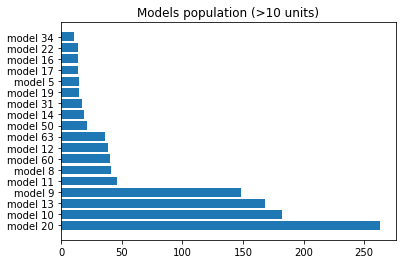

In [33]:
plt.barh(models_population[models_population>10].index,
        models_population[models_population>10].values)
plt.title("Models population (>10 units)")
plt.show()

**Let's see something of the faults**

How many "critical" values and how many records per each one?

In [34]:

df_faults['Critical'].value_counts()


1           192014
CRITICAL     53931
WARNING      44889
Name: Critical, dtype: int64

The alarm type "1" is numeric an not homogeneous with CRITICAL and WARNING 
Let's convert it to a string 

In [35]:
#
# CONVERT INTO ONE ROW IF THEN (see below)
#
def critical_uno(s):
    if s==1:
        return "ONE"
    return s

df_faults['Critical'] = df_faults['Critical'].apply(critical_uno)
df_faults['Critical'].value_counts()

ONE         192014
CRITICAL     53931
WARNING      44889
Name: Critical, dtype: int64

How many error codes per each category?

In [36]:
df_faults[['Critical','ErrorCode']].drop_duplicates()['Critical'].value_counts()

ONE         80
WARNING     53
CRITICAL    38
Name: Critical, dtype: int64

How many error records per error code

In [37]:
df_faults['ErrorCode'].value_counts().sort_index()

1          2
2       2143
3       9600
7          2
8      24091
9        738
11      1223
18      1299
20        14
21       817
22      1200
23       107
24        24
25        16
26        15
       ...  
251       18
252     1334
266       11
270       16
282     2100
283     3197
285     1935
351        6
352       50
366        8
383      682
421        2
451        1
483        6
583        1
Name: ErrorCode, Length: 91, dtype: int64

Let's see this in a bar diagram

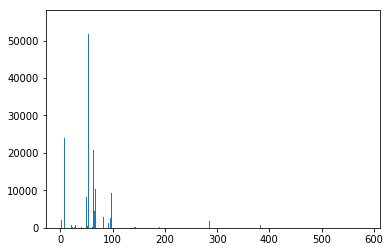

In [38]:
plt.bar(df_faults['ErrorCode'].value_counts().sort_index().index,
       df_faults['ErrorCode'].value_counts().sort_index().values)
plt.show()

What is the error code with the maximum number of occurrencies?

In [39]:
df_faults['ErrorCode'].value_counts().idxmax()

185

What tipe of error is it?

In [40]:
df_faults[df_faults['ErrorCode']==185]['Critical'].value_counts()

ONE         44448
WARNING     10763
CRITICAL       98
Name: Critical, dtype: int64

OK ... the same ErrorCode is of different category... maybe each machine has its own kind of erorr coding?
Let's see how many different 'Critical' values we have for each machine and for each error code:

In [41]:
df_faults.drop_duplicates(['Model','ErrorCode','Critical']).groupby(['Model','ErrorCode'])['Critical'].count()

Model                                   ErrorCode
??? - D41D8CD98F00B204E9800998ECF8427E  99           1
                                        103          1
model 1                                 98           2
                                        99           1
model 10                                3            2
                                        8            2
                                        9            2
                                        18           2
                                        21           2
                                        22           1
                                        24           2
                                        30           1
                                        50           2
                                        51           2
                                        52           2
                                                    ..
model 9                                 64           2
               

**Woops!** looks like the erorr types and error codes are badly mixed... so the error is defined by ErrorCode + Critical

For now I will ignore this weird condition, It will be an issue in the prediction

**Let's see something of the cleanings**

In [42]:
# How many cleaning error codes values and how many records per each one?
df_cleanings['ErrorCode'].value_counts()

1    35938
3    12408
5     9191
2     9167
4     7157
Name: ErrorCode, dtype: int64

Let's merge the cleanings in the faults dataset, by making the dataframe structure uniform.

To avoid mixing error codes, I add 1000 to cleaning codes, and I add the column "Critical" to the df_cleanings for uniformity with the faults dataset

In [43]:
df_cleanings['ErrorCode'] =  df_cleanings['ErrorCode'].add(1000) 
df_cleanings['Critical'] = 'CLEANING'
df_cleanings.head()

,Serial,Week,Model,ErrorCode,Timestamp,Critical
0,1527654,49,model 10,1001,2016-11-29 01:00:13,CLEANING
1,1496767,49,model 7,1001,2016-11-29 00:00:00,CLEANING
2,1557536,49,model 10,1002,2016-11-29 08:00:49,CLEANING
3,1558474,49,model 9,1001,2016-11-29 01:00:35,CLEANING
4,1553390,49,model 13,1001,2016-11-29 00:01:17,CLEANING


Now I can concatenate `df_faults` and `df_cleanings`

In [44]:
df_faults = pd.concat([df_faults,df_cleanings],sort=False)

In [45]:
# Error types per category
df_faults[['Critical','ErrorCode']].drop_duplicates()['Critical'].value_counts()

ONE         80
WARNING     53
CRITICAL    38
CLEANING     5
Name: Critical, dtype: int64

In [46]:
# Most frequent error codes?
df_faults['ErrorCode'].value_counts().head()


185     55309
54      51835
1001    35938
60      29141
8       24091
Name: ErrorCode, dtype: int64

How many faults recorded per model

In [47]:
df_faults['Model'].value_counts()

model 20                                  90743
model 13                                  79880
model 10                                  48821
model 18                                  29073
model 2                                   16203
model 9                                   15048
model 60                                  14830
model 5                                    7413
model 8                                    7153
model 39                                   6394
model 11                                   6007
model 33                                   4865
model 12                                   4840
model 7                                    3592
model 31                                   3220
                                          ...  
model 55                                     44
model 58                                     25
model 51                                     22
model 52                                     20
model 48                                

## Errors distribution across models
To explore this, let's summarize into a dataset indexed by machine model, starting with how many machines there are for each model and how many faults for each model

In [48]:

# Merge models_population with the number of faults recorded
df_issues_summary = pd.concat([models_population,
                               df_faults['Model'].value_counts()], axis=1,sort=False)
# Rename the columns
df_issues_summary.columns = ['Population','Faults']
df_issues_summary.head()

,Population,Faults
model 20,263,90743.0
model 10,182,48821.0
model 13,168,79880.0
model 9,148,15048.0
model 11,46,6007.0


Let's split the faults per type (or severity)

In [49]:
df_faults.groupby(['Critical','Model'])['Serial'].count().unstack(0).sort_values('CRITICAL',ascending=False).head()

Critical,CLEANING,CRITICAL,ONE,WARNING
Model,,,,
model 13,11729.0,36755.0,19616.0,11780.0
model 10,6549.0,12185.0,24904.0,5183.0
model 9,3642.0,1345.0,8785.0,1276.0
model 12,714.0,626.0,3080.0,420.0
model 17,554.0,579.0,1290.0,309.0


Same as above splitting per fault code

In [50]:
df_faults.groupby(['ErrorCode','Model'])['Serial'].count().unstack(0).head()

ErrorCode,1,2,3,7,8,9,11,18,20,21,22,23,24,25,26,27,29,30,31,40,41,42,44,45,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,82,83,84,85,88,89,90,91,92,93,95,96,97,98,99,102,103,142,143,144,145,147,148,151,152,158,166,170,182,183,185,190,251,252,266,270,282,283,285,351,352,366,383,421,451,483,583,1001,1002,1003,1004,1005
Model,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
??? - D41D8CD98F00B204E9800998ECF8427E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,88.0,14.0,15.0,11.0
model 10,NaN,NaN,1313.0,NaN,13404.0,202.0,NaN,496.0,NaN,9.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN,284.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,989.0,10.0,86.0,NaN,12834.0,99.0,2.0,10.0,268.0,10.0,101.0,35.0,362.0,2388.0,103.0,1883.0,1011.0,1737.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,1363.0,349.0,12.0,NaN,121.0,15.0,118.0,43.0,2249.0,334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5213.0,674.0,662.0,NaN,NaN
model 11,NaN,NaN,108.0,NaN,313.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,52.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,14.0,24.0,NaN,10.0,11.0,1.0,1.0,44.0,1.0,NaN,1.0,39.0,1459.0,7.0,61.0,540.0,888.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,136.0,126.0,11.0,NaN,12.0,7.0,19.0,11.0,86.0,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1616.0,102.0,NaN,NaN,NaN
model 12,NaN,NaN,413.0,NaN,888.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,11.0,6.0,NaN,95.0,NaN,6.0,NaN,41.0,NaN,NaN,3.0,25.0,64.0,21.0,81.0,359.0,1556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235.0,4.0,9.0,NaN,18.0,1.0,37.0,19.0,47.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,588.0,50.0,57.0,19.0,NaN


Let's put all together

In [51]:
df_issues_summary = pd.concat([df_issues_summary, 
                               df_faults.groupby(['Critical','Model'])['Serial'].count().unstack(0),
                               df_faults.groupby(['ErrorCode','Model'])['Serial'].count().unstack(0)],sort=False,axis=1)
df_issues_summary.head()

,Population,Faults,CLEANING,CRITICAL,ONE,WARNING,1,2,3,7,8,9,11,18,20,21,22,23,24,25,26,27,29,30,31,40,41,42,44,45,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,82,83,84,85,88,89,90,91,92,93,95,96,97,98,99,102,103,142,143,144,145,147,148,151,152,158,166,170,182,183,185,190,251,252,266,270,282,283,285,351,352,366,383,421,451,483,583,1001,1002,1003,1004,1005
model 20,263,90743.0,289.0,144.0,70686.0,19624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,103.0,NaN,NaN,NaN,NaN,851.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.0,7674.0,NaN,NaN,NaN,NaN,2.0,4.0,24867.0,NaN,194.0,4209.0,NaN,NaN,NaN,NaN,NaN,746.0,76.0,NaN,NaN,NaN,9.0,NaN,NaN,3.0,NaN,10.0,60.0,2.0,6252.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0,NaN,1.0,37.0,NaN,592.0,42835.0,NaN,16.0,4.0,7.0,1.0,310.0,836.0,7.0,3.0,39.0,4.0,540.0,NaN,NaN,3.0,NaN,289.0,NaN,NaN,NaN,NaN
model 10,182,48821.0,6549.0,12185.0,24904.0,5183.0,NaN,NaN,1313.0,NaN,13404.0,202.0,NaN,496.0,NaN,9.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN,284.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,989.0,10.0,86.0,NaN,12834.0,99.0,2.0,10.0,268.0,10.0,101.0,35.0,362.0,2388.0,103.0,1883.0,1011.0,1737.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,1363.0,349.0,12.0,NaN,121.0,15.0,118.0,43.0,2249.0,334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5213.0,674.0,662.0,NaN,NaN
model 13,168,79880.0,11729.0,36755.0,19616.0,11780.0,NaN,NaN,3964.0,NaN,6052.0,7.0,NaN,NaN,NaN,26.0,1139.0,NaN,8.0,NaN,NaN,6.0,NaN,76.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,4878.0,3.0,35.0,NaN,33241.0,109.0,2.0,61.0,203.0,25.0,1.0,24.0,148.0,8498.0,43.0,1869.0,2495.0,2458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,623.0,817.0,11.0,NaN,129.0,69.0,30.0,23.0,458.0,603.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4265.0,3205.0,4259.0,NaN,NaN
model 9,148,15048.0,3642.0,1345.0,8785.0,1276.0,NaN,NaN,552.0,NaN,1369.0,10.0,NaN,NaN,NaN,125.0,50.0,NaN,NaN,NaN,NaN,279.0,NaN,193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1701.0,NaN,54.0,2.0,617.0,54.0,3.0,20.0,161.0,5.0,3.0,11.0,101.0,1501.0,19.0,193.0,958.0,2223.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,524.0,4.0,21.0,NaN,66.0,31.0,78.0,70.0,155.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3132.0,290.0,212.0,8.0,NaN
model 11,46,6007.0,1718.0,578.0,3140.0,571.0,NaN,NaN,108.0,NaN,313.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,52.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,14.0,24.0,NaN,10.0,11.0,1.0,1.0,44.0,1.0,NaN,1.0,39.0,1459.0,7.0,61.0,540.0,888.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,136.0,126.0,11.0,NaN,12.0,7.0,19.0,11.0,86.0,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1616.0,102.0,NaN,NaN,NaN


The absolute number of faults per machine type does not say much. 

Let's compute the *rate* of faults per machine type

In [52]:
# create a dataframe as df_issues_summary with absolute values divided by the number of machines of a certain model
df_issues_summary_rate = df_issues_summary[df_issues_summary.columns[1:]]\
                .div(df_issues_summary['Population'], axis=0)
# add again the population column
df_issues_summary_rate['Population'] = df_issues_summary['Population']

### Worst list - models with higher faults ratio

Only listing models with no less than `minimum_number_of_machines` machines

In [53]:
minimum_number_of_machines = 10

In [54]:
_df = df_issues_summary_rate[df_issues_summary_rate['Population']>=minimum_number_of_machines]

In [55]:
_df[['Population','Faults','ONE','CRITICAL','WARNING','CLEANING']]\
                          .sort_values('Faults',ascending=False)

,Population,Faults,ONE,CRITICAL,WARNING,CLEANING
model 5,15,494.200000,356.666667,1.400000,67.600000,68.533333
model 13,168,475.476190,116.761905,218.779762,70.119048,69.815476
model 60,40,370.750000,354.900000,0.025000,15.825000,NaN
model 20,263,345.030418,268.768061,0.547529,74.615970,1.098859
model 10,182,268.247253,136.835165,66.950549,28.478022,35.983516
model 17,14,195.142857,92.142857,41.357143,22.071429,39.571429
model 31,17,189.411765,171.294118,0.058824,14.000000,4.058824
model 8,41,174.463415,83.219512,13.975610,4.487805,72.780488
model 16,14,157.785714,110.928571,0.142857,0.071429,46.642857
model 50,21,152.095238,130.095238,NaN,20.571429,1.428571


**Higher ratios of missed cleanings**

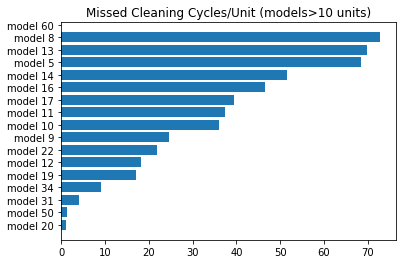

In [56]:
plt.barh(_df['CLEANING'].sort_values().index,
         _df['CLEANING'].sort_values())
plt.title("Missed Cleaning Cycles/Unit (models>10 units)")
plt.show()

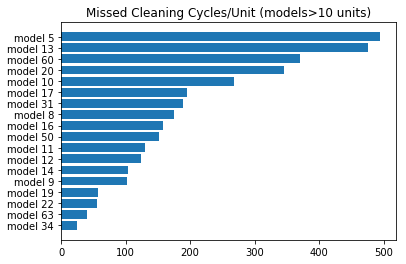

In [57]:
plt.barh(_df['Faults'].sort_values().index,
         _df['Faults'].sort_values())
plt.title("Missed Cleaning Cycles/Unit (models>10 units)")
plt.show()

## Timeline
Before builindg the predictive modes, what is the right timeline for our data? Le't see firs ant last samples of our datasets

**Counters:**

In [58]:
df_counters.groupby('Model').agg({'Timestamp':[min,max]}).sort_values(('Timestamp','min')).head(10)

Timestamp                    
                         min                 max
Model                                           
model 63 1999-11-30 00:07:00 2018-02-07 23:00:24
model 72 1999-11-30 00:07:00 2018-02-07 18:10:26
model 4  2001-02-12 08:50:31 2018-02-07 00:00:33
model 20 2001-03-10 17:05:32 2018-02-07 23:03:15
model 10 2016-03-16 16:44:19 2018-02-07 23:21:09
model 9  2016-10-17 10:00:49 2018-02-07 23:00:31
model 13 2016-11-29 00:00:00 2018-02-07 23:00:59
model 11 2016-11-29 00:00:01 2018-02-07 23:00:30
model 30 2016-11-29 00:00:02 2017-10-20 13:00:29
model 3  2016-11-29 00:00:06 2017-10-18 00:05:28

**Faults**

In [59]:
df_faults.groupby('Model').agg({'Timestamp':[min,max]}).sort_values(('Timestamp','min')).head(10)

Timestamp                    
                         min                 max
Model                                           
model 20 1999-11-30 00:00:00 2018-02-06 22:47:00
model 55 2001-02-12 07:59:00 2018-01-08 09:00:00
model 4  2001-02-12 08:32:00 2018-01-18 00:00:00
model 31 2001-03-05 11:40:00 2018-02-06 23:42:00
model 2  2012-01-04 08:31:00 2018-02-06 00:00:00
model 60 2015-03-25 09:54:00 2018-02-06 20:34:00
model 10 2015-11-03 09:37:19 2018-02-06 23:25:05
model 9  2016-04-24 23:01:25 2018-02-06 21:38:29
model 27 2016-06-01 13:59:00 2018-02-06 00:00:00
model 5  2016-06-05 17:31:00 2018-02-06 20:56:00

Looks like some models were recording faults before having recorded any counter.

Let's consider records >= 2016 (so there are both counters and faults indications)

In [60]:
df_faultsf = df_faults[df_faults['Timestamp']>pd.Timestamp("2016")]
df_countersf = df_counters[df_counters['Timestamp']>pd.Timestamp("2016")]


### Timeline of Faults (absolute)

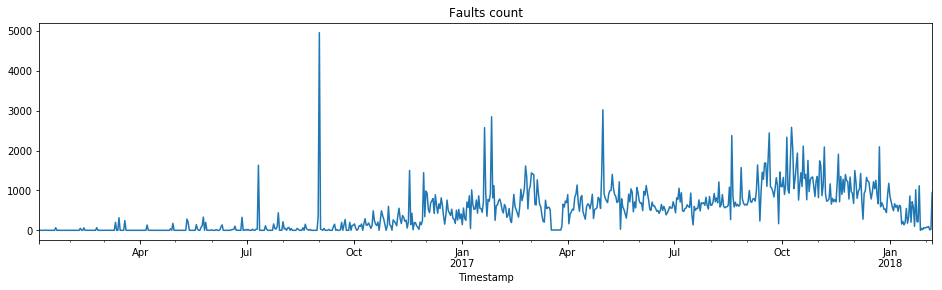

In [61]:
plt.figure(figsize=(16,4))
df_faultsf.groupby('Timestamp')['Critical'].count().resample('D').sum().plot()
plt.title("Faults count")
plt.show()

What is the peak on September 2016??
Let's get the exact day:

In [62]:
df_faultsf.groupby('Timestamp')['Critical'].count().resample('D').sum().idxmax()

Timestamp('2016-09-01 00:00:00', freq='D')

Then filter the dataset looking for only that exact date

In [63]:
bad_day = df_faultsf['Timestamp'].apply(lambda t: t.date())==pd.Timestamp('2016-09-01').date()
df_faultsf[bad_day]

,Serial,Week,Model,ErrorCode,Critical,Timestamp
439,1549699,36,model 39,53,ONE,2016-09-01 00:18:00
440,1549699,36,model 39,53,ONE,2016-09-01 01:07:00
441,1549699,36,model 39,53,ONE,2016-09-01 01:55:00
442,1549699,36,model 39,53,ONE,2016-09-01 04:00:00
443,1549699,36,model 39,53,ONE,2016-09-01 04:09:00
444,1549699,36,model 39,53,ONE,2016-09-01 04:35:00
445,1549699,36,model 39,53,ONE,2016-09-01 04:38:00
446,1549699,36,model 39,53,ONE,2016-09-01 04:58:00
447,1549699,36,model 39,53,ONE,2016-09-01 05:14:00
448,1549699,36,model 39,53,ONE,2016-09-01 05:26:00


May be just few machines going mad?

In [64]:
df_faultsf[bad_day]['Critical'].value_counts()

ONE         4840
CLEANING     116
Name: Critical, dtype: int64

In [65]:
df_faultsf[bad_day]['Serial'].value_counts()

1549699    4840
1421318     116
Name: Serial, dtype: int64

So looks like one machine, SN 1549699 (model 39) had a very bad day and one other, SN 1421318 missed 116 times the cleanings in the same day.

Looking for crazy number of errors on the same machine or missed cleanings multiple times in the same day may be a pattern to look at for cleaning the data, but I'm not yet doing it

### Timeline of Faults (per fault type)

Let's split the faults timeline across faults types.

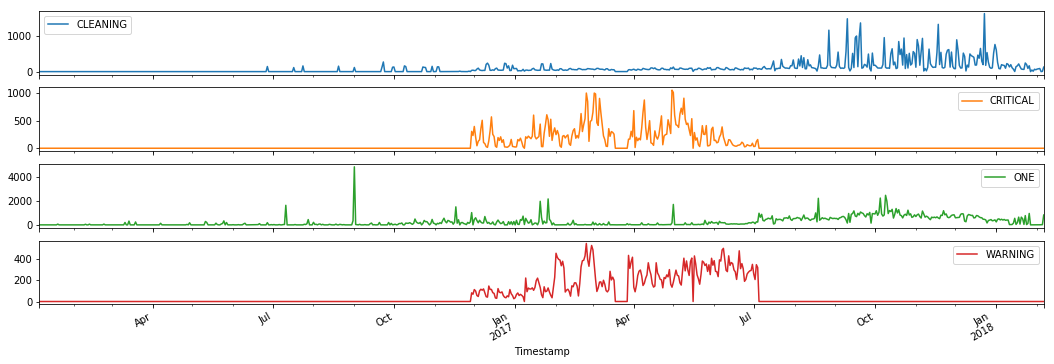

In [66]:
df_faultsf.groupby(['Critical','Timestamp'])['Serial'].count()\
           .unstack('Critical').resample('D').sum().plot(figsize=(18,6),subplots=True)
plt.show()

The distribution is quite strange:
* "CRITICAL" and "WARNING" faults types have been observed only in a time window from end 2016 until august 2017 or so.
* "CLEANING" events are  concentrated after mid 2017
* "ONE" events are distributed across all timeline

*be careful:* the orders of magnitude are very different: CLEANING and ONE are in the hundreds, others in the units.
Resampling over Weeks instead of days brings scales back in line amonng fault types

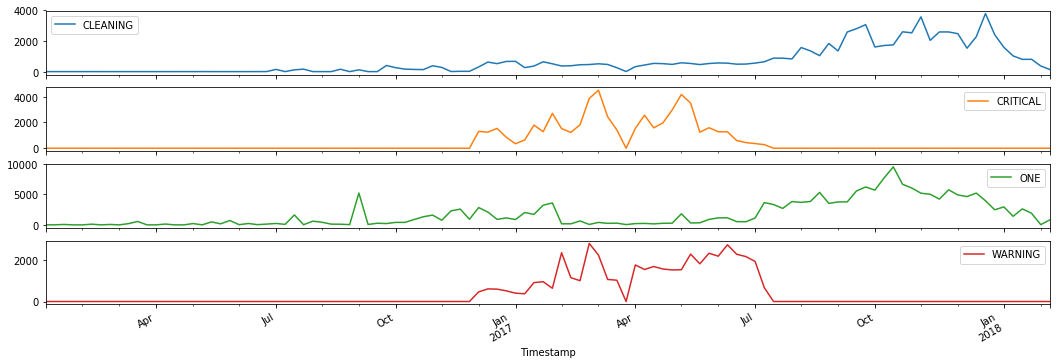

In [67]:
df_faultsf.groupby(['Critical','Timestamp'])['Serial'].count()\
           .unstack('Critical').resample('W').sum().plot(figsize=(18,6),subplots=True)
plt.show()

### Timeline of faults (per machine type)

Look only at the top 4 machines in terms of population 

In [68]:
models_to_look = models_population.sort_values(ascending=False)[:4].index


Let's resample on Week basis from the beginning

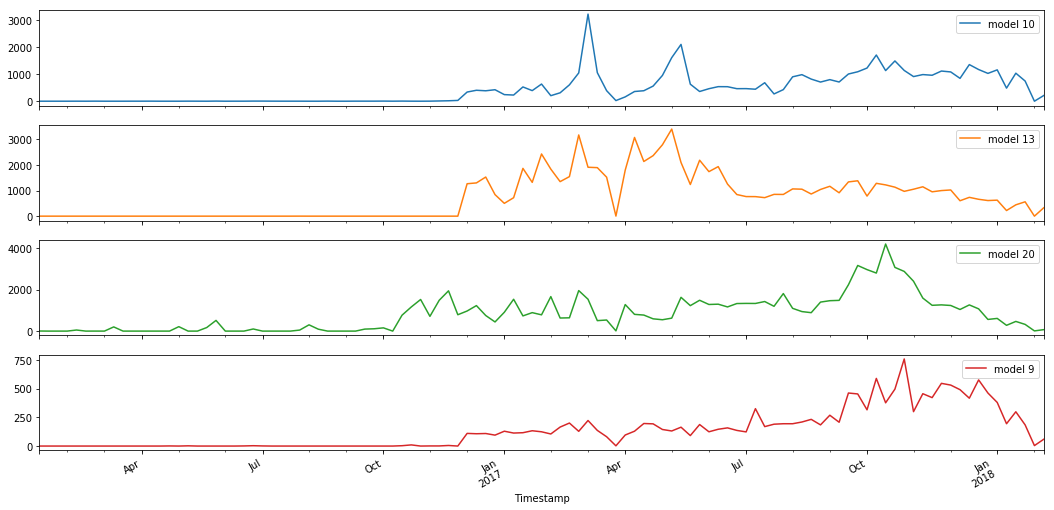

In [69]:
df_faultsf[df_faultsf['Model'].isin(models_to_look)]\
           .groupby(['Model','Timestamp'])['Serial'].count()\
           .unstack('Model').resample('W').sum().plot(figsize=(18,9),subplots=True)
plt.show()

### Timeline on counters (per machine type)

Let's check when exactly machines start genereting counters

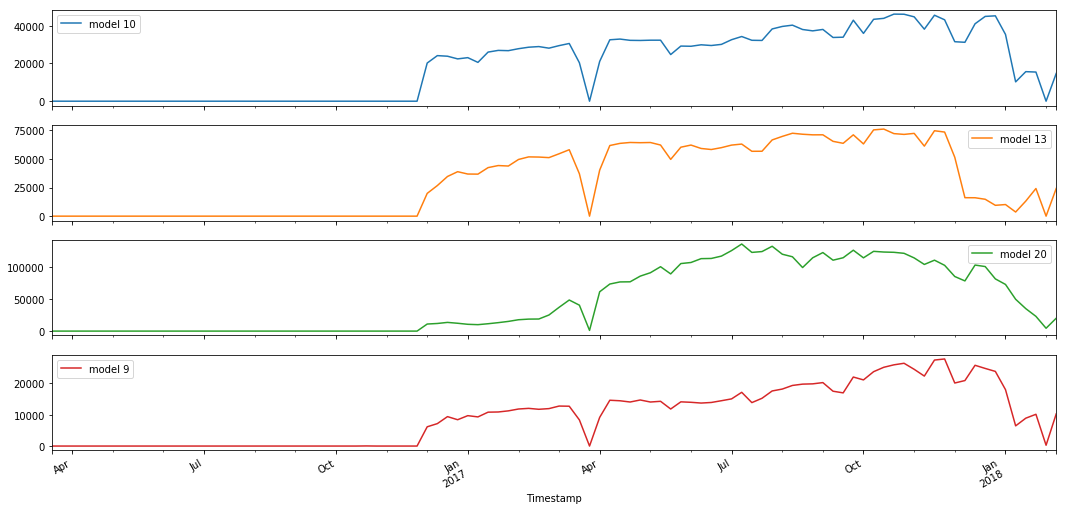

In [70]:
df_countersf[df_countersf['Model'].isin(models_to_look)]\
            .groupby(['Model','Timestamp'])['Serial'].count().unstack('Model')\
            .resample('W').sum().plot(figsize=(18,9),subplots=True)
plt.show()

So no much sense in looking for anything before Oct 2017

# Building the dataset for prediction

I will build a datset for predicting faults based on previous faults and missed cleanings.
The dataset will be extended also including counters, but I had problems I cannot yet fix :-(

The datset format will be like the following 


Serial | Model | Timestamp | FAULT-4D | FAULT-3D | FAULT-2D | FAULT-1D | CLEANING-4D | CLEANING-3D | CLEANING-2D | CLEANING-1D | TARGET |
-------|-------|-----------|----------|----------|----------|----------|-------------|-------------|-------------|---------------------|--------|
1535632 | model 62 | 2017-02-12 00:00:00 | 0 |  1 |  0 |  5 |  0 |   0 |  0 | 2 | 0  |  
1425579 | model 20 | 2017-03-06 00:00:00 | 1 | 36 | 18 |  2 |  0 |  12 | 90 | 2 | 11 | 

The parameters are the sampling rate and depth.
In the example above the sampling rate is one day (`D`) and the depth is 4 days.

`FAULT-4D` means how many errors have been registered by that machine 4 Days ahead fo the target day

`FAULT-3D` means how many errors have been registered by that machine 3 Days ahead fo the target day, and so on

`CLEANING-4D` means how many errors have been registered by that machine 4 Days ahead fo the target day, and so on

`Timestamp` is referred to the Target event we want to predict

`TARGET` is the target of the prediction. In the present notebook it is the number of errors on the target day.

The depth makes sense of much more days, say at least 10 but 30 wold make better sense. The period could be weeks (`W`) to make a smaller dataset.

In [71]:
df_faultsf.head()

,Serial,Week,Model,ErrorCode,Critical,Timestamp
0,1496700,49,model 62,285,WARNING,2016-11-29 16:57:00
1,1458460,49,model 20,185,WARNING,2016-11-29 19:54:00
2,1528607,49,model 20,185,WARNING,2016-11-29 14:44:00
3,1528607,49,model 20,185,WARNING,2016-11-29 17:34:00
4,1425579,49,model 20,185,WARNING,2016-11-29 17:19:00


I will need a lookup table between Serial numbers and Models

Wait a minute... let's check if association between SN and model is coherent. And let's concatenate both faults and counters dataframes, to make sure to collect all!

In [72]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
    .groupby('Serial')['Model'].count().sort_values(ascending=False).head()


Serial
1536009    2
1587623    2
1566832    1
1566315    1
1566316    1
Name: Model, dtype: int64

Looks like there are few SN associated to more than one mode, let's see:

In [73]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
    .groupby('Serial').get_group('1587623')

,Serial,Model
2595,1587623,??? - D41D8CD98F00B204E9800998ECF8427E
1079,1587623,model 11


This is easy - the crazy string is an error - Let's fix this once and forever:

In [74]:
# if-then on one column, see
# http://pandas-docs.github.io/pandas-docs-travis/user_guide/cookbook.html
df_faultsf.loc[df_faultsf['Serial']=='1587623','Model'] = 'model 11'
df_countersf.loc[df_countersf['Serial']=='1587623','Model'] = 'model 11'


C:\Users\emamorc\AppData\Local\conda\conda\envs\fastai\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


We have a warning but I'm not sure this is appropriate. Actually we are doing right what the warning suggests.

Let's see the other duplicated SN

In [75]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
    .groupby('Serial').get_group('1536009')

,Serial,Model
64632,1536009,model 55
47612,1536009,model 63


This is worst... which will be true? Let's check by majority

In [76]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]])\
            .set_index('Serial').loc['1536009']['Model'].value_counts()

model 63    57
model 55    47
Name: Model, dtype: int64

Hard choice --- they are sort of the same amount. Let's see how they are in the timeline

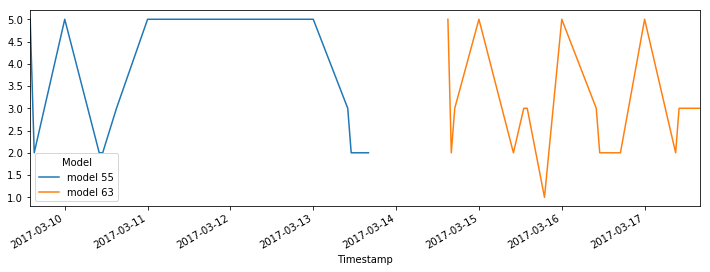

In [77]:
pd.concat([df_faultsf[['Serial','Model','Timestamp']],df_countersf[['Serial','Model','Timestamp']]])\
            .set_index('Serial').loc['1536009'].reset_index().groupby(['Timestamp','Model'])['Serial'].count()\
            .unstack('Model').plot(figsize=(12,4))

Let's assume the right one is the last one, i.e. "model 63" 

In [78]:
# if-then on one column, see
# http://pandas-docs.github.io/pandas-docs-travis/user_guide/cookbook.html
df_faultsf.loc[df_faultsf['Serial']=='1536009','Model'] = 'model 63'
df_countersf.loc[df_countersf['Serial']=='1536009','Model'] = 'model 63'


And finally check if all is OK

In [79]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
    .groupby('Serial')['Model'].count().sort_values(ascending=False).head()

Serial
1709778    1
1566832    1
1566315    1
1566316    1
1566317    1
Name: Model, dtype: int64

Now I can build a safe lookup table!

In [80]:
sn_model_lookup =pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
                            .set_index('Serial').sort_index()
sn_model_lookup.head()

,Model
Serial,
1000002,model 17
1000009,model 17
1100001,model 15
1111222,model 1
1111333,model 20


### Subsetting the Serial Numbers

To run experiments I limit the number of serial numbers to play with to the ones with more fault records associated, using `value_counts`

In [110]:
how_many_serials = 100 # set this to -1 to pick all serials

In [111]:
if how_many_serials > 0:
    top_serial = df_faultsf['Serial'].value_counts().head(how_many_serials).index
else:
    top_serial = df_faultsf['Serial'].value_counts().index
    
top_serial

Index(['1555490', '1612713', '1554481', '1558041', '1625343', '1421318',
       '1654182', '1427255', '1601009', '1285802', '1549699', '1482253',
       '1604016', '1558697', '1551067', '1582026', '1576749', '1481132',
       '1544482', '1544574', '1558464', '1542283', '1601443', '1573607',
       '1646375', '1500287', '1496767', '1343587', '1620407', '1481421',
       '1535632', '1565929', '1523289', '1595292', '1493944', '1555491',
       '1557338', '1479635', '1582533', '1555492', '1565593', '1590516',
       '1600162', '1645785', '1607903', '1605207', '1551003', '1590352',
       '1585809', '1557349', '1111333', '1558465', '1565931', '1563845',
       '1543636', '1524236', '1565271', '1592330', '1565272', '1607900',
       '1605676', '1631867', '1592091', '1592688', '1491315', '1468215',
       '1557339', '1644549', '1555493', '1529836', '1617246', '1429483',
       '1614139', '1565930', '1490446', '1605684', '1381715', '1607774',
       '1565623', '1269672', '1592333', '1519694', 

### Manipulation of faults dataframe
I copy in a new DataFrame the subset fo the filtered fault dataframe, with further filter on the Serial numbers, and removing the "Week" column which we don't use and the "Model" column we don't need any more as we have the lookup table


In [112]:
my_faults_mask = df_faultsf['Serial'].isin(set(top_serial))
_df_faults = df_faultsf[my_faults_mask].drop(['Week','Model'],axis=1).copy()

I transoform all the error lables like "CRITICAL", "WARNING", "ONE" into just one label "FAULT".

In [113]:
# if-then on one column, see
# http://pandas-docs.github.io/pandas-docs-travis/user_guide/cookbook.html
_df_faults.loc[_df_faults['Critical'] != 'CLEANING','Critical'] = 'FAULT'

### Time period setting
This is the time period between samples in each row of the final dataset

In [114]:
time_period = 'W'

Let's group the records by Serial, Timestamp and Critical column, counting the error codes. I am making no distinction on the error code numbers either. The `groupby` method plus the aggregation function (in this case `count`) produces a multi index series. With the `unstack` method I move the fields I want in the columns out of tyhe index, and then I `resample` on the required frequency, with further aggregation (now it is `sum`)

In [115]:
gb_df = _df_faults.groupby(['Serial','Timestamp','Critical'])['ErrorCode'].count()\
        .unstack(['Serial','Critical'])\
        .resample(time_period).sum()
print(len(gb_df))
gb_df.head()

93


Serial      1111333        1269672        1285802        1343587        \
Critical   CLEANING FAULT CLEANING FAULT CLEANING FAULT CLEANING FAULT   
Timestamp                                                                
2016-05-08      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-15      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-22      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-29      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-06-05      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   

Serial     1381715          1408157  1421318       1427255  1429483        \
Critical     FAULT CLEANING   FAULT CLEANING FAULT   FAULT CLEANING FAULT   
Timestamp                                                                   
2016-05-08     0.0      0.0     0.0      0.0   0.0     0.0      0.0   0.0   
2016-05-15     0.0      0.0     0.0      0.0   0.0     0.0      0.0   0.0   
2016-05-22     0.0      0.0     0.0      0.0   0.0     0.0      0.0   0.0   
2016-05-29     0.0      0.0     0.0      0.0   0.0     0.0      0.0   0.0   
2016-06-05     0.0      0.0     0.0      0.0   0.0     0.0      0.0   0.0   

Serial      1450350       1468215 1479635 1481132          1481421 1482253  \
Critical   CLEANING FAULT   FAULT   FAULT   FAULT CLEANING   FAULT   FAULT   
Timestamp                                                                    
2016-05-08      0.0   0.0     0.0     0.0     0.0      0.0     0.0     0.0   
2016-05-15      0.0   0.0     0.0     0.0     0.0      0.0     0.0     0.0   
2016-05-22      0.0   0.0     0.0     0.0     0.0      0.0     0.0     0.0   
2016-05-29      0.0   0.0     0.0     0.0     0.0      0.0     0.0     0.0   
2016-06-05      0.0   0.0     0.0     0.0     0.0      0.0     0.0     0.0   

Serial     1490446          1491315 1493944           1496767       1497159  \
Critical     FAULT CLEANING   FAULT   FAULT CLEANING CLEANING FAULT   FAULT   
Timestamp                                                                     
2016-05-08     0.0      0.0     0.0     0.0      0.0      0.0   0.0     0.0   
2016-05-15     0.0      0.0     0.0     0.0      0.0      0.0   0.0     0.0   
2016-05-22     0.0      0.0     0.0     0.0      0.0      0.0   0.0     0.0   
2016-05-29     0.0      0.0     0.0     0.0      0.0      0.0   0.0     0.0   
2016-06-05    18.0      0.0     0.0     0.0      0.0      0.0   0.0     0.0   

Serial     1500287 1517618 1519204 1519694 1523289          1524236 1529836  \
Critical     FAULT   FAULT   FAULT   FAULT   FAULT CLEANING   FAULT   FAULT   
Timestamp                                                                     
2016-05-08     1.0     0.0     0.0     0.0     0.0      0.0     0.0     0.0   
2016-05-15     1.0     0.0     0.0     0.0     0.0      0.0     0.0     0.0   
2016-05-22     0.0     0.0     0.0     0.0     0.0      0.0     0.0     0.0   
2016-05-29     1.0     0.0     0.0     0.0     0.0      0.0     0.0     0.0   
2016-06-05     0.0     0.0     0.0     0.0     0.0      0.0     0.0     0.0   

Serial              1535632  1542283       1543626          1543636           \
Critical   CLEANING   FAULT CLEANING FAULT   FAULT CLEANING   FAULT CLEANING   
Timestamp                                                                      
2016-05-08      0.0     0.0      0.0   0.0     0.0      0.0     0.0      0.0   
2016-05-15      0.0     0.0      0.0   0.0     0.0      0.0     0.0      0.0   
2016-05-22      0.0     0.0      0.0   0.0     0.0      0.0     0.0      0.0   
2016-05-29      0.0     0.0      0.0   0.0     0.0      0.0     0.0      0.0   
2016-06-05      0.0     0.0      0.0   0.0     0.0      0.0     0.0      0.0   

Serial      1544482       1544574 1549699 1551003  1551067       1554481  \
Critical   CLEANING FAULT   FAULT   FAULT   FAULT CLEANING FAULT   FAULT   
Timestamp                                                                  
2016-05-08      0.0   0.0     

Not all serial numbers have associated both CLEANING and FAULT columns, thus I have to reindex creating a `MultiIndex` including all the columns. The added columns will be zero filled. I'm not sure this is the simpler way to do this...

In [116]:
serials = gb_df.columns.get_level_values('Serial').unique()
items = gb_df.columns.get_level_values('Critical').unique()
new_index = pd.MultiIndex.from_product([serials,items], names=['Serial', 'Critical'])
gb_df = gb_df.reindex(new_index,fill_value=0.0,axis=1)
gb_df.head()

Serial      1111333        1269672        1285802        1343587        \
Critical   CLEANING FAULT CLEANING FAULT CLEANING FAULT CLEANING FAULT   
Timestamp                                                                
2016-05-08      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-15      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-22      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-29      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-06-05      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   

Serial      1381715        1408157        1421318        1427255        \
Critical   CLEANING FAULT CLEANING FAULT CLEANING FAULT CLEANING FAULT   
Timestamp                                                                
2016-05-08      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-15      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-22      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-29      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-06-05      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   

Serial      1429483        1450350        1468215        1479635        \
Critical   CLEANING FAULT CLEANING FAULT CLEANING FAULT CLEANING FAULT   
Timestamp                                                                
2016-05-08      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-15      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-22      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-29      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-06-05      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   

Serial      1481132        1481421        1482253        1490446        \
Critical   CLEANING FAULT CLEANING FAULT CLEANING FAULT CLEANING FAULT   
Timestamp                                                                
2016-05-08      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-15      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-22      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-29      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-06-05      0.0   0.0      0.0   0.0      0.0   0.0      0.0  18.0   

Serial      1491315        1493944        1496767        1497159        \
Critical   CLEANING FAULT CLEANING FAULT CLEANING FAULT CLEANING FAULT   
Timestamp                                                                
2016-05-08      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-15      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-22      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-29      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-06-05      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   

Serial      1500287        1517618        1519204        1519694        \
Critical   CLEANING FAULT CLEANING FAULT CLEANING FAULT CLEANING FAULT   
Timestamp                                                                
2016-05-08      0.0   1.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-15      0.0   1.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-22      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-29      0.0   1.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-06-05      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   

Serial      1523289        1524236        1529836        1535632        \
Critical   CLEANING FAULT CLEANING FAULT CLEANING FAULT CLEANING FAULT   
Timestamp                                                                
2016-05-08      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-15      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0   
2016-05-22      0.0   0.0      0.0   0.0      0.0   0.0      0.0   0.0  

### Depth, step and target setting

With `depth = 10` there will be 10 coulumns with FAULTS history and 10 columns with CLEANING history in the dataset.

With `step = 1` between one row and the next row of the same Serial there will be a shift one period.

The target coulumn in the dataset will be the vale of the column FAULT after "depth" steps

In [117]:
depth = 20
step  = 1
target_field = 'FAULT'

### Loop to build the dataset

To build the dataset I will loop across the the series shifting the initial timestamp, for each serial number and for "depth" steps at each time 

In [118]:
# Intialize an empty DataFrame
dataset = pd.DataFrame()

# I get the list of values from the grouped dataframes to make sure I will loop over existing serials and items
serials = gb_df.columns.get_level_values('Serial').unique()
fault_items = gb_df.columns.get_level_values('Critical').unique()
#counter_items = gb_dc.columns.get_level_values('LabelCounter').unique()

# start stopwatch ... this will take long
start = dt.datetime.now()
for base in range(0,len(gb_df)-depth,step):
    for sn in serials:
        if base + depth < len(gb_df):
            # Initialize the Series which will be the new row in the dataset
            # Actually I will stack the Series in columns, making a transpose operation ot the end
            # The first elements are
            # Serial number
            # Model (looked up in the lookup table)
            # Timestamp, which is the base time + depth as I want the timestamp of the target
            s = pd.Series([sn,sn_model_lookup.loc[sn]['Model'],gb_df.index[base+depth]],
                        index = ['Serial','Model','Target Timestamp'])
            # Then the features are the possible items in the fault dataframe (FAULT and CLEANING).
            # I keep the code as general as possible to support extensions
            for i in fault_items:
                # The piece of Series is bult with list comprehension, and the index as well.
                # I am not using multi indexing to make things easier for the prediction model
                s = pd.concat([s,pd.Series(gb_df[base:base+depth][sn][i].values,
                                           index=["%s-%d%s"%(i,depth-n,time_period) for n in range(depth)])]) 

# I am Not adding counters because the counter series is not sycngronized with faultseries :-(
#            for i in counter_items:
#                s = pd.concat([s,pd.Series(gb_dc[base:base+depth][sn][i].values,index=["%s-%d%s"%(i,depth-n,time_period) for n in range(depth)])]) 
            
            # Last piece of the row is the TARGET columns
            s = pd.concat([s,pd.Series(gb_df.iloc[base+depth][sn][target_field],index=['TARGET'])])
            
            # Adding the series to the datafarme
            dataset = pd.concat([dataset,s],axis=1,sort=False)
            
    progress(base, len(gb_df)-depth-1, status='Building dataset')

print('\n',(dt.datetime.now()-start))



[============================================================] 100.0% ...Building dataset
 0:02:29.495112


In [119]:
dataset = dataset.T.reset_index().drop('index',axis=1)
dataset.head(20)

,Serial,Model,Target Timestamp,CLEANING-20W,CLEANING-19W,CLEANING-18W,CLEANING-17W,CLEANING-16W,CLEANING-15W,CLEANING-14W,CLEANING-13W,CLEANING-12W,CLEANING-11W,CLEANING-10W,CLEANING-9W,CLEANING-8W,CLEANING-7W,CLEANING-6W,CLEANING-5W,CLEANING-4W,CLEANING-3W,CLEANING-2W,CLEANING-1W,FAULT-20W,FAULT-19W,FAULT-18W,FAULT-17W,FAULT-16W,FAULT-15W,FAULT-14W,FAULT-13W,FAULT-12W,FAULT-11W,FAULT-10W,FAULT-9W,FAULT-8W,FAULT-7W,FAULT-6W,FAULT-5W,FAULT-4W,FAULT-3W,FAULT-2W,FAULT-1W,TARGET
0,1111333,model 20,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1269672,model 45,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1285802,model 2,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1343587,model 2,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,142,0,0,160,0,0,0,153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1381715,model 20,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1408157,model 20,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1421318,model 2,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,114,0,0,0,0,0,0,116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1427255,model 20,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1429483,model 2,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1450350,model 6,2016-09-25 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [120]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 44 columns):
Serial              7300 non-null object
Model               7300 non-null object
Target Timestamp    7300 non-null object
CLEANING-20W        7300 non-null object
CLEANING-19W        7300 non-null object
CLEANING-18W        7300 non-null object
CLEANING-17W        7300 non-null object
CLEANING-16W        7300 non-null object
CLEANING-15W        7300 non-null object
CLEANING-14W        7300 non-null object
CLEANING-13W        7300 non-null object
CLEANING-12W        7300 non-null object
CLEANING-11W        7300 non-null object
CLEANING-10W        7300 non-null object
CLEANING-9W         7300 non-null object
CLEANING-8W         7300 non-null object
CLEANING-7W         7300 non-null object
CLEANING-6W         7300 non-null object
CLEANING-5W         7300 non-null object
CLEANING-4W         7300 non-null object
CLEANING-3W         7300 non-null object
CLEANING-2W         7300 non-nul

Saving the file with key informations in the name: number of serials, time period, depth and step.

In [121]:
file_name = "Faults_Cleaning_%d_%s_%d_%d.csv"%(len(top_serial),time_period,depth,step)
print("Saving ",file_name)
dataset.to_csv(file_name)

Saving  Faults_Cleaning_100_W_20_1.csv


## Merge Faults and Counters

To have a single timeline I will merge the two datasets of Faults and Counters. Let's start by getting counters in the same kind of subset as done for tha faults

In [122]:
my_counters_mask = df_countersf['Serial'].isin(set(top_serial))
_df_counters = df_countersf[my_counters_mask].drop(['Week','Model'],axis=1)


In [123]:
_df_counters.head()

,Serial,LabelCounter,AbsoluteCounter,RelativeCounter,Timestamp
0,1535632,numcaffegenerale,179112.0,0.0,2016-11-29 00:00:38
5,1535632,numcaffegenerale,179120.0,8.0,2016-11-29 05:00:07
6,1535632,numcaffegenerale,179158.0,38.0,2016-11-29 06:00:07
7,1535632,numcaffegenerale,179228.0,70.0,2016-11-29 07:00:07
8,1535632,numcaffegenerale,179327.0,99.0,2016-11-29 08:00:07


In [124]:
_df_faults.head()

,Serial,ErrorCode,Critical,Timestamp
6,1468215,185,FAULT,2016-11-29 15:24:00
7,1468215,185,FAULT,2016-11-29 16:31:00
8,1468215,185,FAULT,2016-11-29 17:43:00
9,1517618,185,FAULT,2016-11-29 18:15:00
10,1517618,185,FAULT,2016-11-29 18:59:00


We will convert the faults DataFrame in a format compatible with the counters dataframe, introducing Relative and Absolute counters. Relative counter is easy: each Record will be a single event, so each row will have relative counter = 1

In [125]:
_df_faults['RelativeCounter'] = 1

But for absolute I have to identify the portions of dataset relavent to a certain serial and a certain type of fault, and count the events.

In [126]:
serials = list(sn_model_lookup.index)
for sn in serials:
    # To be as general as possible I get the list of items associated to each serial number every time
    items = _df_faults[_df_faults['Serial']==sn]['Critical'].unique()
    if len(items)>0:
        for i in items:
            _df_faults.loc[(_df_faults['Serial']==sn)&(_df_faults['Critical']==i),'AbsoluteCounter'] = \
                    _df_faults.groupby(['Serial','Critical']).get_group((sn,i))['RelativeCounter'].cumsum()

Let's give a look (now I will sample some rows at random)

In [136]:
_df_faults.sample(5)

,Serial,ErrorCode,Critical,Timestamp,RelativeCounter,AbsoluteCounter
68,1558465,1003,CLEANING,2017-07-26 17:15:27,1,152.0
128,1555490,54,FAULT,2017-04-07 15:57:16,1,19149.0
181,1427255,185,FAULT,2016-11-12 21:57:00,1,2859.0
250,1427255,185,FAULT,2017-01-07 08:46:00,1,3929.0
60,1523289,8,FAULT,2017-12-06 15:12:53,1,1260.0


Next steps: rename Crticial into LabelCounter and remove "ErrorCode"

In [137]:
_df_faults['LabelCounter'] = _df_faults['Critical']
_df_faults = _df_faults.drop(['ErrorCode','Critical'],axis = 1)
_df_faults.head()

,Serial,Timestamp,RelativeCounter,AbsoluteCounter,LabelCounter
6,1468215,2016-11-29 15:24:00,1,1.0,FAULT
7,1468215,2016-11-29 16:31:00,1,2.0,FAULT
8,1468215,2016-11-29 17:43:00,1,3.0,FAULT
9,1517618,2016-11-29 18:15:00,1,1.0,FAULT
10,1517618,2016-11-29 18:59:00,1,2.0,FAULT


# READY TO MERGE!!!!

Let's give another look to the counters df, final check if it matches the faults df:

In [138]:
_df_counters.head()

,Serial,LabelCounter,AbsoluteCounter,RelativeCounter,Timestamp
0,1535632,numcaffegenerale,179112.0,0.0,2016-11-29 00:00:38
5,1535632,numcaffegenerale,179120.0,8.0,2016-11-29 05:00:07
6,1535632,numcaffegenerale,179158.0,38.0,2016-11-29 06:00:07
7,1535632,numcaffegenerale,179228.0,70.0,2016-11-29 07:00:07
8,1535632,numcaffegenerale,179327.0,99.0,2016-11-29 08:00:07


Let's concatenate the two:

In [139]:
_df_faults_and_counters = pd.concat([_df_counters,_df_faults],sort=False)
_df_faults_and_counters.sample(10)

,Serial,LabelCounter,AbsoluteCounter,RelativeCounter,Timestamp
7430,1517618,ngr2,256.0,5.00000,2017-01-25 18:03:51
29953,1592333,tempogr1,1896.8,135.40002,2017-07-23 09:00:18
4787,1479635,numcaffegenerale,335049.0,12.00000,2017-08-02 15:00:29
44203,1554481,numcaffegr1,80729.0,15.00000,2017-10-31 10:00:26
20069,1555490,nummac1gr1,7674.0,1.00000,2017-03-06 18:00:20
63818,1482253,numcaffegr1,8428784.0,8.00000,2017-09-01 08:00:33
16866,1557338,numcicligr1,45833.0,7.00000,2016-12-12 16:00:05
151605,1646375,numcaffegenerale,17297.0,12.00000,2017-07-24 10:01:45
55475,1544574,numcaffegr2,62371.0,3.00000,2017-11-16 13:13:56
147180,1592091,numlattegr1,6887.0,0.00000,2017-11-20 00:00:57


In [140]:
gb_df_fc = _df_faults_and_counters.groupby(['Serial','Timestamp','LabelCounter'])['RelativeCounter'].sum()\
        .unstack(['Serial','LabelCounter'])\
        .resample(time_period,).sum()
print(len(gb_df_fc))
gb_df_fc.head()

93


Serial        1111333                                                       \
LabelCounter numacqua numcaffegenerale numcaffegr1 numcaffegr2 numcaffegr3   
Timestamp                                                                    
2016-05-08        0.0              0.0         0.0         0.0         0.0   
2016-05-15        0.0              0.0         0.0         0.0         0.0   
2016-05-22        0.0              0.0         0.0         0.0         0.0   
2016-05-29        0.0              0.0         0.0         0.0         0.0   
2016-06-05        0.0              0.0         0.0         0.0         0.0   

Serial                                                                  \
LabelCounter CLEANING numvaporeariats numvaporets FAULT ngr1 ngr2 ngr3   
Timestamp                                                                
2016-05-08        0.0             0.0         0.0   0.0  0.0  0.0  0.0   
2016-05-15        0.0             0.0         0.0   0.0  0.0  0.0  0.0   
2016-05-22        0.0             0.0         0.0   0.0  0.0  0.0  0.0   
2016-05-29        0.0             0.0         0.0   0.0  0.0  0.0  0.0   
2016-06-05        0.0             0.0         0.0   0.0  0.0  0.0  0.0   

Serial                                                                    \
LabelCounter portatagr1 portatagr2 portatagr3 tempogr1 tempogr2 tempogr3   
Timestamp                                                                  
2016-05-08          0.0        0.0        0.0      0.0      0.0      0.0   
2016-05-15          0.0        0.0        0.0      0.0      0.0      0.0   
2016-05-22          0.0        0.0        0.0      0.0      0.0      0.0   
2016-05-29          0.0        0.0        0.0      0.0      0.0      0.0   
2016-06-05          0.0        0.0        0.0      0.0      0.0      0.0   

Serial                1269672                                        \
LabelCounter numcaffegenerale numcaffegr1 numcicligr1 numcioccolato   
Timestamp                                                             
2016-05-08                0.0         0.0         0.0           0.0   
2016-05-15                0.0         0.0         0.0           0.0   
2016-05-22                0.0         0.0         0.0           0.0   
2016-05-29                0.0         0.0         0.0           0.0   
2016-06-05                0.0         0.0         0.0           0.0   

Serial                                                                     \
LabelCounter numlattegr1 nummac1gr1 nummac2gr1 numsolubile CLEANING FAULT   
Timestamp                                                                   
2016-05-08           0.0        0.0        0.0         0.0      0.0   0.0   
2016-05-15           0.0        0.0        0.0         0.0      0.0   0.0   
2016-05-22           0.0        0.0        0.0         0.0      0.0   0.0   
2016-05-29           0.0        0.0        0.0         0.0      0.0   0.0   
2016-06-05           0.0        0.0        0.0         0.0      0.0   0.0   

Serial                1285802                                        \
LabelCounter numcaffegenerale numcaffegr1 numcicligr1 numcioccolato   
Timestamp                                                             
2016-05-08                0.0         0.0         0.0           0.0   
2016-05-15                0.0         0.0         0.0           0.0   
2016-05-22                0.0         0.0         0.0           0.0   
2016-05-29                0.0         0.0         0.0           0.0   
2016-06-05                0.0         0.0         0.0           0.0   

Serial                                                                 \
LabelCounter numlattefr numlattegr1 nummac1gr1 nummac2gr1 numsolubile   
Timestamp                                                               
2016-05-08          0.0         0.0        0.0        0.0         0.0   
2016-05-15          0.0         0.0        0.0        0.0         0.0   
2016-05-22          0.0         0.0        0.0       

Clean up the DataFrame by adding missing columns and sorting

In [141]:
serials = gb_df_fc.columns.get_level_values('Serial').unique()
items = gb_df_fc.columns.get_level_values('LabelCounter').unique()
new_index = pd.MultiIndex.from_product([serials,items], names=['Serial', 'LabelCounter'])
gb_df_fc = gb_df_fc.reindex(new_index,fill_value=0,axis=1).sort_index(axis=1)
gb_df_fc.head()

Serial        1111333                                                      \
LabelCounter CLEANING FAULT ngr1 ngr2 ngr3 ngr4 numacqua numcaffegenerale   
Timestamp                                                                   
2016-05-08        0.0   0.0  0.0  0.0  0.0    0      0.0              0.0   
2016-05-15        0.0   0.0  0.0  0.0  0.0    0      0.0              0.0   
2016-05-22        0.0   0.0  0.0  0.0  0.0    0      0.0              0.0   
2016-05-29        0.0   0.0  0.0  0.0  0.0    0      0.0              0.0   
2016-06-05        0.0   0.0  0.0  0.0  0.0    0      0.0              0.0   

Serial                                                                    \
LabelCounter numcaffegr1 numcaffegr2 numcaffegr3 numcaffegr4 numcicligr1   
Timestamp                                                                  
2016-05-08           0.0         0.0         0.0           0           0   
2016-05-15           0.0         0.0         0.0           0           0   
2016-05-22           0.0         0.0         0.0           0           0   
2016-05-29           0.0         0.0         0.0           0           0   
2016-06-05           0.0         0.0         0.0           0           0   

Serial                                                                   \
LabelCounter numcioccolato numlattefr numlattegr1 nummac1gr1 nummac2gr1   
Timestamp                                                                 
2016-05-08               0          0           0          0          0   
2016-05-15               0          0           0          0          0   
2016-05-22               0          0           0          0          0   
2016-05-29               0          0           0          0          0   
2016-06-05               0          0           0          0          0   

Serial                                                                     \
LabelCounter numsolubile numvapore numvaporeariats numvaporets portatagr1   
Timestamp                                                                   
2016-05-08             0         0             0.0         0.0        0.0   
2016-05-15             0         0             0.0         0.0        0.0   
2016-05-22             0         0             0.0         0.0        0.0   
2016-05-29             0         0             0.0         0.0        0.0   
2016-06-05             0         0             0.0         0.0        0.0   

Serial                                                                    \
LabelCounter portatagr2 portatagr3 portatagr4 tempogr1 tempogr2 tempogr3   
Timestamp                                                                  
2016-05-08          0.0        0.0          0      0.0      0.0      0.0   
2016-05-15          0.0        0.0          0      0.0      0.0      0.0   
2016-05-22          0.0        0.0          0      0.0      0.0      0.0   
2016-05-29          0.0        0.0          0      0.0      0.0      0.0   
2016-06-05          0.0        0.0          0      0.0      0.0      0.0   

Serial                 1269672                                     \
LabelCounter tempogr4 CLEANING FAULT ngr1 ngr2 ngr3 ngr4 numacqua   
Timestamp                                                           
2016-05-08          0      0.0   0.0    0    0    0    0        0   
2016-05-15          0      0.0   0.0    0    0    0    0        0   
2016-05-22          0      0.0   0.0    0    0    0    0        0   
2016-05-29          0      0.0   0.0    0    0    0    0        0   
2016-06-05          0      0.0   0.0    0    0    0    0        0   

Serial                                                                         \
LabelCounter numcaffegenerale numcaffegr1 numcaffegr2 numcaffegr3 numcaffegr4   
Timestamp                                                                       
2016-05-08                0.0         0.0           0           0           0   
2016-05-15                0.0         0.0           0           0     

And let's go with the dataset creation

In [142]:
# Intialize an empty DataFrame
dataset = pd.DataFrame()

# I get the list of values from the grouped dataframes to make sure I will loop over existing serials and items
serials = gb_df_fc.columns.get_level_values('Serial').unique()
items = gb_df_fc.columns.get_level_values('LabelCounter').unique()

# start stopwatch ... this will take long
start = dt.datetime.now()
for base in range(0,len(gb_df_fc)-depth,step):
    for sn in serials:
        if base + depth < len(gb_df_fc):
            # Initialize the Series which will be the new row in the dataset
            # Actually I will stack the Series in columns, making a transpose operation ot the end
            # The first elements are
            # Serial number
            # Model (looked up in the lookup table)
            # Timestamp, which is the base time + depth as I want the timestamp of the target
            s = pd.Series([sn,sn_model_lookup.loc[sn]['Model'],gb_df_fc.index[base+depth]],
                        index = ['Serial','Model','Target Timestamp'])
            # Then the features are the possible items in the fault dataframe (FAULT and CLEANING).
            # I keep the code as general as possible to support extensions
            for i in items:
                # The piece of Series is bult with list comprehension, and the index as well.
                # I am not using multi indexing to make things easier for the prediction model
                s = pd.concat([s,pd.Series(gb_df_fc[base:base+depth][sn][i].values,
                                           index=["%s-%d%s"%(i,depth-n,time_period) for n in range(depth)])]) 
            
            # Last piece of the row is the TARGET columns
            s = pd.concat([s,pd.Series(gb_df_fc.iloc[base+depth][sn][target_field],index=['TARGET'])])
            
            # Adding the series to the datafarme
            dataset = pd.concat([dataset,s],axis=1,sort=False)
            
    progress(base, len(gb_df_fc)-depth-1, status='Building dataset')

print('\n',(dt.datetime.now()-start))



[============================================================] 100.0% ...Building dataset
 0:51:42.396486


In [143]:
dataset = dataset.T.reset_index().drop('index',axis=1)

In [144]:
dataset.sample(10)

,Serial,Model,Target Timestamp,CLEANING-20W,CLEANING-19W,CLEANING-18W,CLEANING-17W,CLEANING-16W,CLEANING-15W,CLEANING-14W,CLEANING-13W,CLEANING-12W,CLEANING-11W,CLEANING-10W,CLEANING-9W,CLEANING-8W,CLEANING-7W,CLEANING-6W,CLEANING-5W,CLEANING-4W,CLEANING-3W,CLEANING-2W,CLEANING-1W,FAULT-20W,FAULT-19W,FAULT-18W,FAULT-17W,FAULT-16W,FAULT-15W,FAULT-14W,FAULT-13W,FAULT-12W,FAULT-11W,FAULT-10W,FAULT-9W,FAULT-8W,FAULT-7W,FAULT-6W,FAULT-5W,FAULT-4W,FAULT-3W,FAULT-2W,FAULT-1W,ngr1-20W,ngr1-19W,ngr1-18W,ngr1-17W,ngr1-16W,ngr1-15W,ngr1-14W,ngr1-13W,ngr1-12W,ngr1-11W,ngr1-10W,ngr1-9W,ngr1-8W,ngr1-7W,ngr1-6W,ngr1-5W,ngr1-4W,ngr1-3W,ngr1-2W,ngr1-1W,ngr2-20W,ngr2-19W,ngr2-18W,ngr2-17W,ngr2-16W,ngr2-15W,ngr2-14W,ngr2-13W,ngr2-12W,ngr2-11W,ngr2-10W,ngr2-9W,ngr2-8W,ngr2-7W,ngr2-6W,ngr2-5W,ngr2-4W,ngr2-3W,ngr2-2W,ngr2-1W,ngr3-20W,ngr3-19W,ngr3-18W,ngr3-17W,ngr3-16W,ngr3-15W,ngr3-14W,ngr3-13W,ngr3-12W,ngr3-11W,ngr3-10W,ngr3-9W,ngr3-8W,ngr3-7W,ngr3-6W,ngr3-5W,ngr3-4W,ngr3-3W,ngr3-2W,ngr3-1W,ngr4-20W,ngr4-19W,ngr4-18W,ngr4-17W,ngr4-16W,ngr4-15W,ngr4-14W,ngr4-13W,ngr4-12W,ngr4-11W,ngr4-10W,ngr4-9W,ngr4-8W,ngr4-7W,ngr4-6W,ngr4-5W,ngr4-4W,ngr4-3W,ngr4-2W,ngr4-1W,numacqua-20W,numacqua-19W,numacqua-18W,numacqua-17W,numacqua-16W,numacqua-15W,numacqua-14W,numacqua-13W,numacqua-12W,numacqua-11W,numacqua-10W,numacqua-9W,numacqua-8W,numacqua-7W,numacqua-6W,numacqua-5W,numacqua-4W,numacqua-3W,numacqua-2W,numacqua-1W,numcaffegenerale-20W,numcaffegenerale-19W,numcaffegenerale-18W,numcaffegenerale-17W,numcaffegenerale-16W,numcaffegenerale-15W,numcaffegenerale-14W,numcaffegenerale-13W,numcaffegenerale-12W,numcaffegenerale-11W,numcaffegenerale-10W,numcaffegenerale-9W,numcaffegenerale-8W,numcaffegenerale-7W,numcaffegenerale-6W,numcaffegenerale-5W,numcaffegenerale-4W,numcaffegenerale-3W,numcaffegenerale-2W,numcaffegenerale-1W,numcaffegr1-20W,numcaffegr1-19W,numcaffegr1-18W,numcaffegr1-17W,numcaffegr1-16W,numcaffegr1-15W,numcaffegr1-14W,numcaffegr1-13W,numcaffegr1-12W,numcaffegr1-11W,numcaffegr1-10W,numcaffegr1-9W,numcaffegr1-8W,numcaffegr1-7W,numcaffegr1-6W,numcaffegr1-5W,numcaffegr1-4W,numcaffegr1-3W,numcaffegr1-2W,numcaffegr1-1W,numcaffegr2-20W,numcaffegr2-19W,numcaffegr2-18W,numcaffegr2-17W,numcaffegr2-16W,numcaffegr2-15W,numcaffegr2-14W,numcaffegr2-13W,numcaffegr2-12W,numcaffegr2-11W,numcaffegr2-10W,numcaffegr2-9W,numcaffegr2-8W,numcaffegr2-7W,numcaffegr2-6W,numcaffegr2-5W,numcaffegr2-4W,numcaffegr2-3W,numcaffegr2-2W,numcaffegr2-1W,numcaffegr3-20W,numcaffegr3-19W,numcaffegr3-18W,numcaffegr3-17W,numcaffegr3-16W,numcaffegr3-15W,numcaffegr3-14W,numcaffegr3-13W,numcaffegr3-12W,numcaffegr3-11W,numcaffegr3-10W,numcaffegr3-9W,numcaffegr3-8W,numcaffegr3-7W,numcaffegr3-6W,numcaffegr3-5W,numcaffegr3-4W,numcaffegr3-3W,numcaffegr3-2W,numcaffegr3-1W,numcaffegr4-20W,numcaffegr4-19W,numcaffegr4-18W,numcaffegr4-17W,numcaffegr4-16W,numcaffegr4-15W,numcaffegr4-14W,numcaffegr4-13W,numcaffegr4-12W,numcaffegr4-11W,numcaffegr4-10W,numcaffegr4-9W,numcaffegr4-8W,numcaffegr4-7W,numcaffegr4-6W,numcaffegr4-5W,numcaffegr4-4W,numcaffegr4-3W,numcaffegr4-2W,numcaffegr4-1W,numcicligr1-20W,numcicligr1-19W,numcicligr1-18W,numcicligr1-17W,numcicligr1-16W,numcicligr1-15W,numcicligr1-14W,numcicligr1-13W,numcicligr1-12W,numcicligr1-11W,numcicligr1-10W,numcicligr1-9W,numcicligr1-8W,numcicligr1-7W,numcicligr1-6W,numcicligr1-5W,numcicligr1-4W,numcicligr1-3W,numcicligr1-2W,numcicligr1-1W,numcioccolato-20W,numcioccolato-19W,numcioccolato-18W,numcioccolato-17W,numcioccolato-16W,numcioccolato-15W,numcioccolato-14W,numcioccolato-13W,numcioccolato-12W,numcioccolato-11W,numcioccolato-10W,numcioccolato-9W,numcioccolato-8W,numcioccolato-7W,numcioccolato-6W,numcioccolato-5W,numcioccolato-4W,numcioccolato-3W,numcioccolato-2W,numcioccolato-1W,numlattefr-20W,numlattefr-19W,numlattefr-18W,numlattefr-17W,numlattefr-16W,numlattefr-15W,numlattefr-14W,numlattefr-13W,numlattefr-12W,numlattefr-11W,numlattefr-10W,numlattefr-9W,numlattefr-8W,numlattefr-7W,numlattefr-6W,numlattefr-5W,numlattefr-4W,numlattefr-3W,numlattefr-2

In [145]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Columns: 604 entries, Serial to TARGET
dtypes: object(604)
memory usage: 33.6+ MB


In [146]:
file_name = "Faults_Cleaning_Counters_%d_%s_%d_%d.csv"%(len(top_serial),time_period,depth,step)
print("Saving ",file_name)
dataset.to_csv(file_name)

Saving  Faults_Cleaning_Counters_100_W_20_1.csv
